In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

## Defining the Boltzmann machine model inside an object 

In [2]:
class boltzmanmachine:
    
    def __init__(self, N, L, M, sigma, De, vmin, spin=True):
        self.w = np.random.normal(loc=0.0, scale=sigma, size=(L,M))
        self.a = np.random.normal(loc=0.0, scale=sigma, size=L)
        self.b = b = np.zeros(M)
        
        
        self.w = sigma * np.random.randn(L,M)
        self.a = sigma * np.random.randn(L)
        self.b = b = np.zeros(M)
        
        self.spin=spin
        
        self.DE = De
        self.N = int(N)
        self.L = int(L)
        self.M = int(M)
        self.vmin=vmin
        
        self.v_data, self.v_model = None, None
        self.h_data, self.h_model = None, None
        self.vh_data,self.vh_model= None, None
        
        if self.spin:
            self.csi1 = np.array([1,-1,-1,-1])    
            self.csi2 = np.array([-1,1,-1,-1])   
            self.csi3 = np.array([-1,-1,1,-1])    
            self.csi4 = np.array([-1,-1,-1,1])  
        else:
            self.csi1 = np.array([1,0,0,0])    
            self.csi2 = np.array([0,1,0,0])   
            self.csi3 = np.array([0,0,1,0])    
            self.csi4 = np.array([0,0,0,1]) 
            
        

        self.csi = [self.csi1, self.csi2, self.csi3, self.csi4]
        
        #algotithm variables
        self.sa_t0 = 0
        self.sb_t0 = 0
        self.sw_t0 = 0
        
        self.ma_t0 = 0
        self.mb_t0 = 0
        self.mw_t0 = 0
        
        
    def init_avg(self):
        self.v_data, self.v_model = np.zeros(self.L),np.zeros(self.L)
        self.h_data, self.h_model = np.zeros(self.M),np.zeros(self.M)
        self.vh_data,self.vh_model= np.zeros((self.L,self.M)),np.zeros((self.L,self.M))
        
        
        
    def positive(self, v_in, Amp=1.):
        act = np.dot(v_in, self.w) + self.b      
        #print(act)
        argument=np.exp(-Amp*self.DE*act)
        prob = 1. / (1. + argument)
        n = np.shape(act)
        h = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        h[np.random.random_sample(n) < prob] = 1
        
        return h
    
    def neg(self, h_in, Amp=1.):
        act = np.dot(h_in, self.w.T) + self.a      
        #print(act)
        prob = 1. / (1. + np.exp(-Amp*self.DE*act))
        n = np.shape(act)
        vf = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        vf[np.random.random_sample(n) < prob] = 1
        
        return vf
    
    
    def negative(self, h_in, Amp=1.):
        
        weigths = np.reshape(np.dot(h_in, self.w.T) + self.a, (5,4) ) 

        
        E1 = np.dot(weigths, self.csi1) #array of length 5, the number of amminoacids
        E2 = np.dot(weigths, self.csi2)
        E3 = np.dot(weigths, self.csi3)
        E4 = np.dot(weigths, self.csi4)
        


        Z = np.exp(-Amp*E1) + np.exp(-Amp*E2) + np.exp(-Amp*E3) + np.exp(-Amp*E4) #partition function for each amminoacid
        
        p1 = np.exp(-Amp*E1)/Z 
        p2 = np.exp(-Amp*E2)/Z
        p3 = np.exp(-Amp*E3)/Z
        p4 = np.exp(-Amp*E4)/Z
        
        
        
        p = np.reshape(np.concatenate((p1, p2, p3, p4)), (4, 5))      

        
        cum = np.cumsum(p, axis=0) #(4x5) containing the comulatives  
        r = np.random.random(size=5)        
        
        mask = cum < r    
        indx = []    
        
        for i in range(mask.shape[1]):
            __, index = np.unique(mask[:, i], return_index=True)
            indx.append(index[0])
            
        vf=np.concatenate((self.csi[indx[0]], self.csi[indx[1]], self.csi[indx[2]], self.csi[indx[3]], self.csi[indx[4]]))
        return vf
        
    
    def update_vh(self, v_k, vf, h, hf):
        self.v_data  += v_k
        self.v_model += vf
        self.h_data  += h
        self.h_model += hf
        self.vh_data += np.outer(v_k.T,h)
        self.vh_model+= np.outer(vf.T,hf)
    
    def SGD(self, l_rate):
        dw = l_rate_m*(self.vh_data - self.vh_model)
        da = l_rate_m*(self.v_data - self.v_model)
        db = l_rate_m*(self.h_data - self.h_model)
        
        self.w += dw
        self.a += da
        self.b += db
        
    def RMSprop(self, eta_t, beta=0.9, epsilon=1e-8):
        
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model
        
        sa_t = beta*self.sa_t0 + (1-beta)*ga_t**2
        sb_t = beta*self.sb_t0 + (1-beta)*gb_t**2
        sw_t = beta*self.sw_t0 + (1-beta)*gw_t**2
        
        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t
        
        
        self.a = self.a + eta_t*ga_t/np.sqrt(sa_t + epsilon)
        self.b = self.b + eta_t*gb_t/np.sqrt(sb_t + epsilon)
        self.w = self.w + eta_t*gw_t/np.sqrt(sw_t + epsilon)
        
        
    def ADAM(self, eta_t, epoch, beta1=0.9, beta2=0.99,epsilon=1e-8):
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model

        ma_t = beta1*self.ma_t0 + (1-beta1)*ga_t
        mb_t = beta1*self.mb_t0 + (1-beta1)*gb_t
        mw_t = beta1*self.mw_t0 + (1-beta1)*gw_t

        sa_t = beta2*self.sa_t0 + (1-beta2)*ga_t**2
        sb_t = beta2*self.sb_t0 + (1-beta2)*gb_t**2
        sw_t = beta2*self.sw_t0 + (1-beta2)*gw_t**2

        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t

        self.ma_t0 = ma_t
        self.mb_t0 = mb_t
        self.mw_t0 = mw_t

        ma_t_hat = ma_t/(1-beta1**epoch) 
        mb_t_hat = mb_t/(1-beta1**epoch) 
        mw_t_hat = mw_t/(1-beta1**epoch)

        sa_t_hat = sa_t/(1-beta2**epoch) 
        sb_t_hat = sb_t/(1-beta2**epoch) 
        sw_t_hat = sw_t/(1-beta2**epoch)

        self.a = self.a + eta_t*ma_t_hat/(np.sqrt(sa_t_hat) + epsilon)
        self.b = self.b + eta_t*mb_t_hat/(np.sqrt(sb_t_hat) + epsilon)
        self.w = self.w + eta_t*mw_t_hat/(np.sqrt(sw_t_hat) + epsilon)
    

## Defining global variable which will control the training process

In [3]:
seed = 1
Amp_train = 0.5
moving_temperature = False
Amp_train_mov_init = np.copy(Amp_train)
Amp_train_mov_end = 0.05 
Amp_gen = 1
cdn  = 1.
epochs = 100

## Importing data and pre-process them in order to switch from bit to spins

In [4]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...


In [5]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 6
# range of each initial weight

sigma = np.sqrt(4. / float(L + M))
# random seed for reproducibility

np.random.seed(seed)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
rbm = boltzmanmachine(N,L,M,sigma,GAP, vmin, spin=SPINS)

print("w=",rbm.w);print("a=",rbm.a);print("b=",rbm.b)
w0,a0,b0=np.copy(rbm.w),np.copy(rbm.a),np.copy(rbm.b)

w= [[-7.31786852e-02 -3.99080146e-02  3.40805190e-01  2.94335661e-01
   2.07673386e-01  5.40108582e-02]
 [ 3.05239577e-02  2.42548694e-01  9.11918688e-02  2.67718688e-01
  -1.21637806e-01 -9.55021944e-01]
 [ 4.07460532e-01  8.57803992e-01  1.73117378e-01 -3.92841145e-02
  -5.35180317e-02 -4.66968944e-02]
 [ 6.82853174e-03 -4.40091953e-01 -2.02821133e-01 -3.91066096e-01
   9.75870599e-02 -1.16352233e-01]
 [ 1.94237862e-01 -6.85242170e-02  3.86872490e-01  8.37548869e-02
   8.59263128e-01 -7.43813950e-01]
 [-2.53741601e-01  3.53592250e-01  9.91690932e-01 -9.75225833e-02
   1.71283883e-02 -8.87677491e-02]
 [ 5.22240446e-01 -1.12691416e-01  2.66745337e-01 -1.25436507e-01
  -4.99138610e-01  1.22983534e-01]
 [ 1.97365322e-01  5.07244924e-01 -4.33208879e-02 -2.42149324e-01
   2.20733063e-01  9.44248562e-02]
 [ 1.10085900e-01 -2.86771618e-02  4.55122232e-01  1.44926967e-01
   7.47068609e-01  4.35792291e-01]
 [ 2.58500598e-01 -6.38333835e-01  2.36249059e-01  1.64848243e-01
   3.18081416e-01  4.0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]


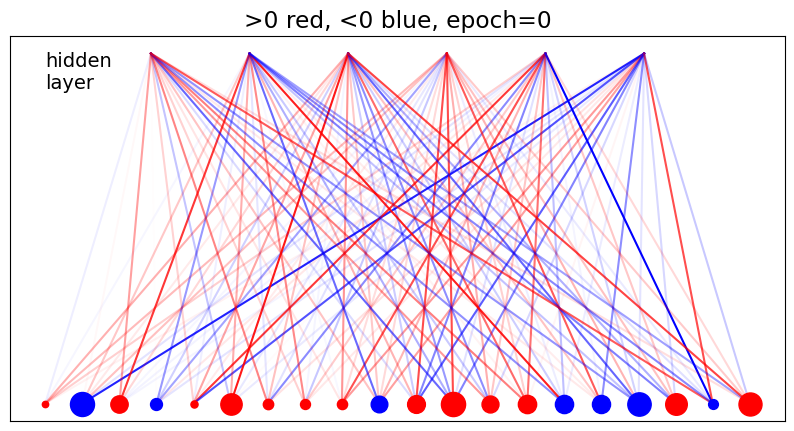

In [6]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch, w, M, a, b):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph(0, rbm.w, M, rbm.a, rbm.b)

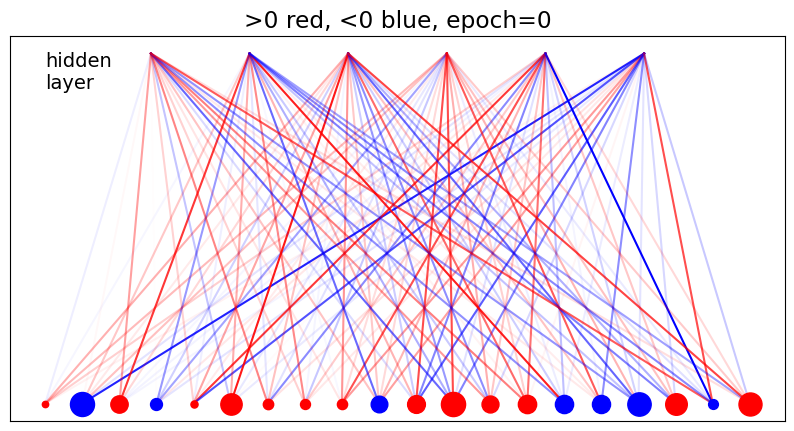

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


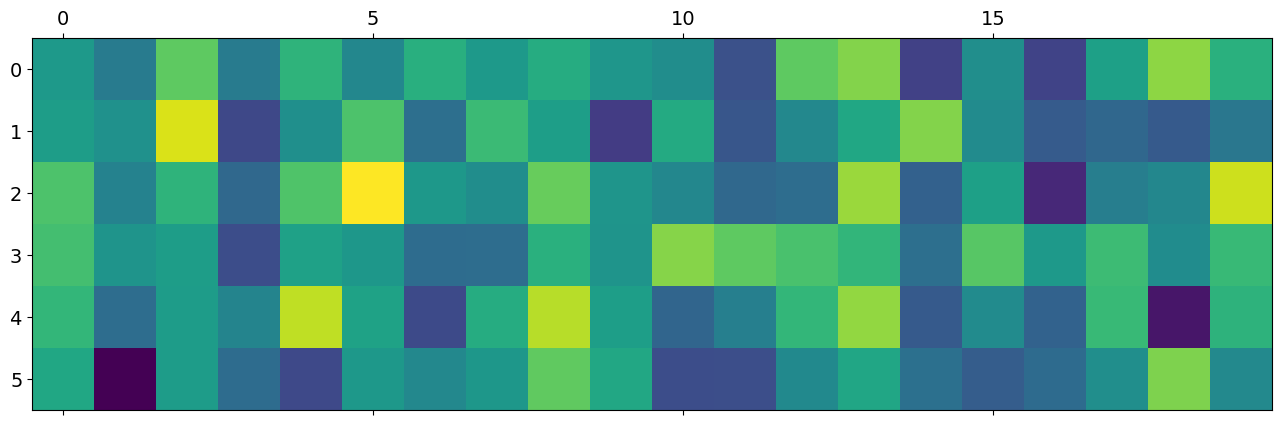

10
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


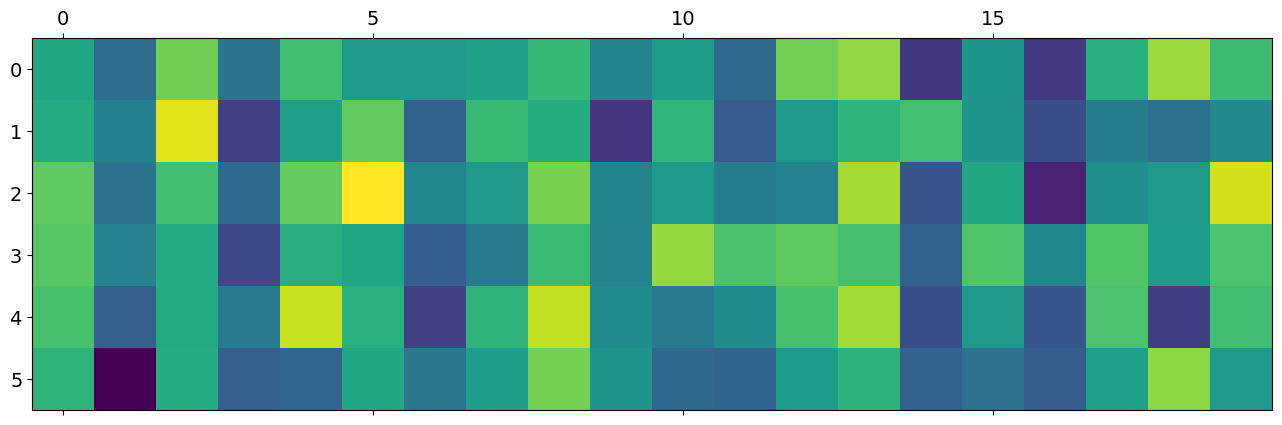

20
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


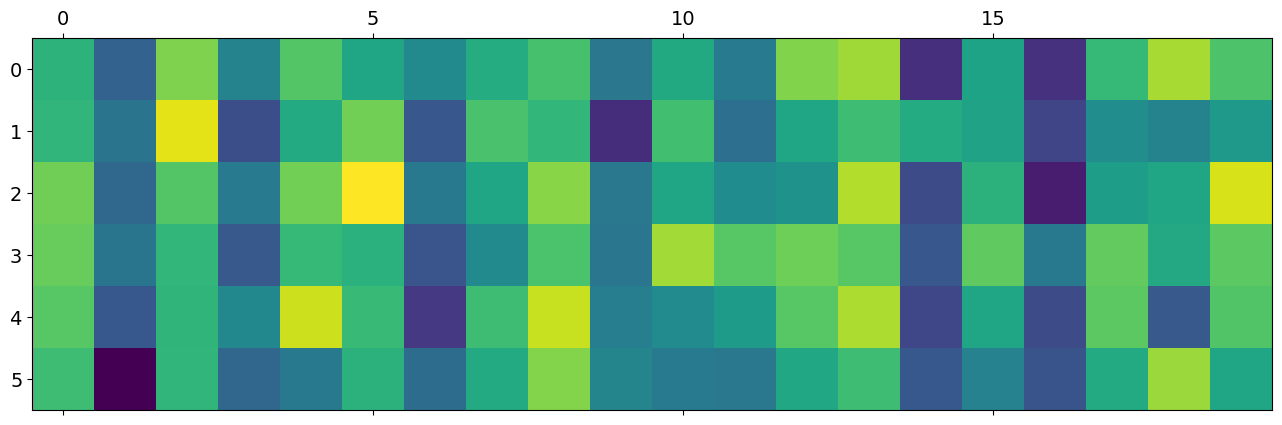

30
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


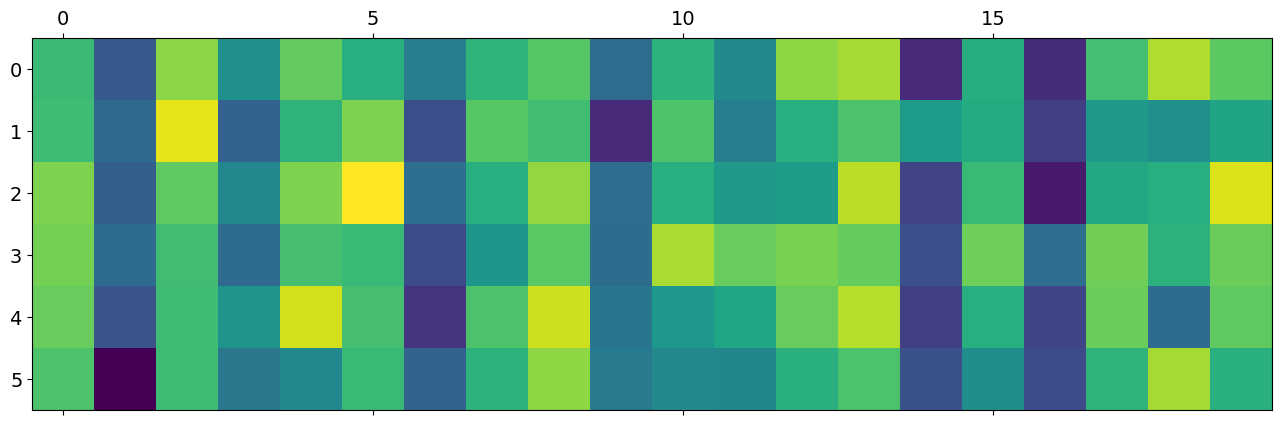

40
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


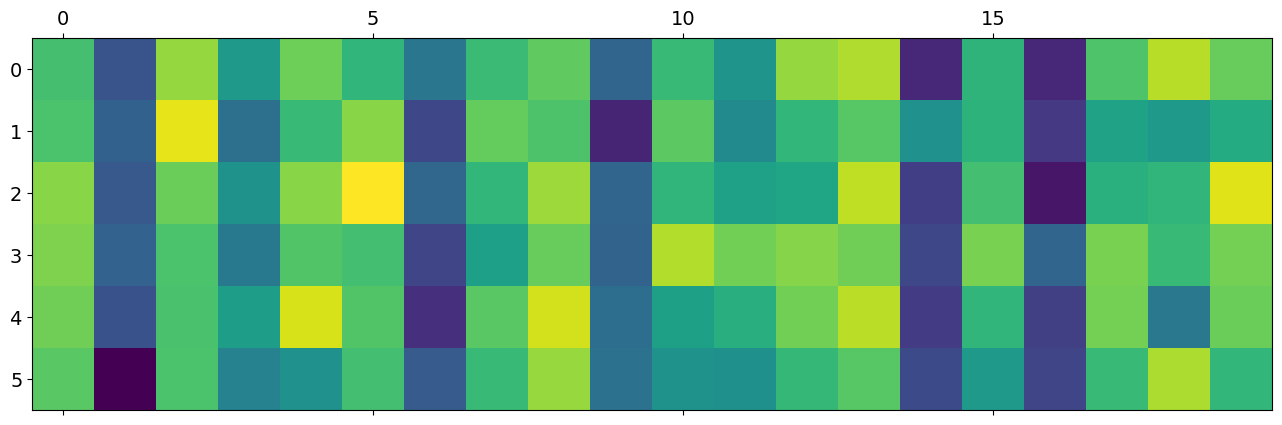

50
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


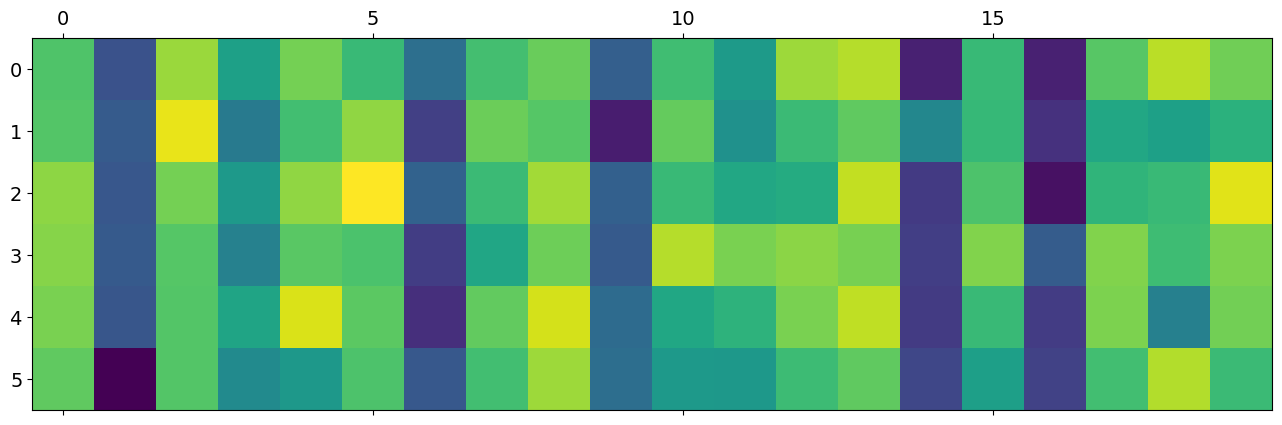

60
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


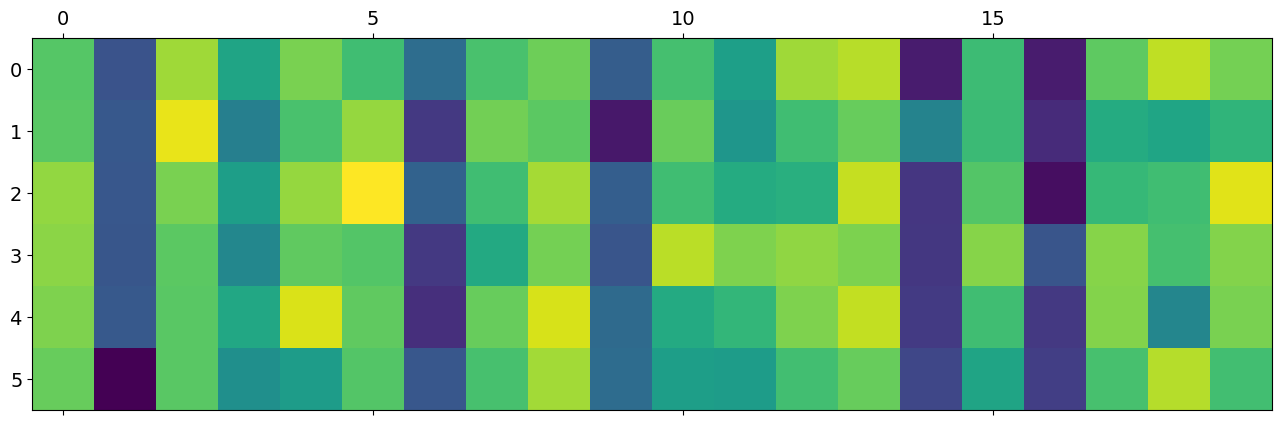

70
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


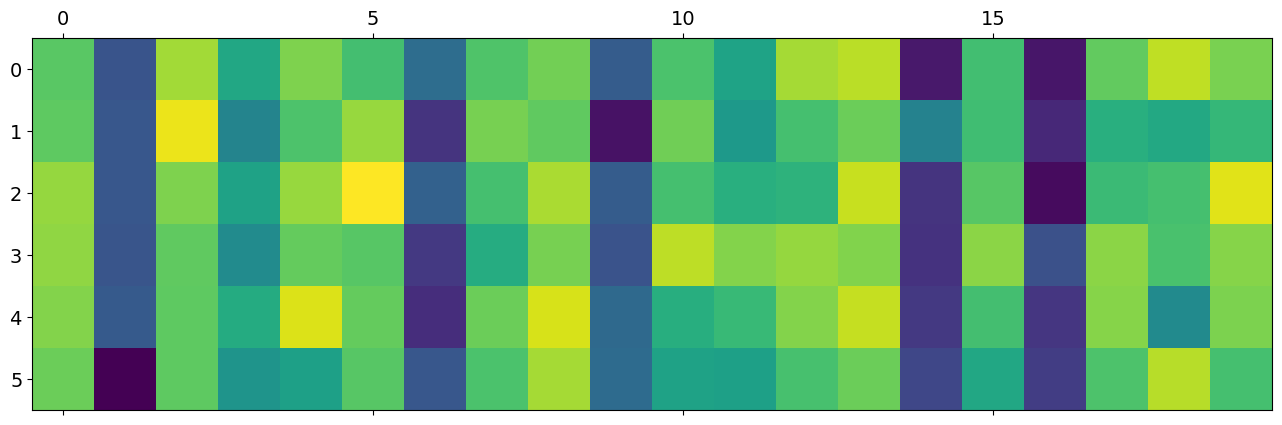

80
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


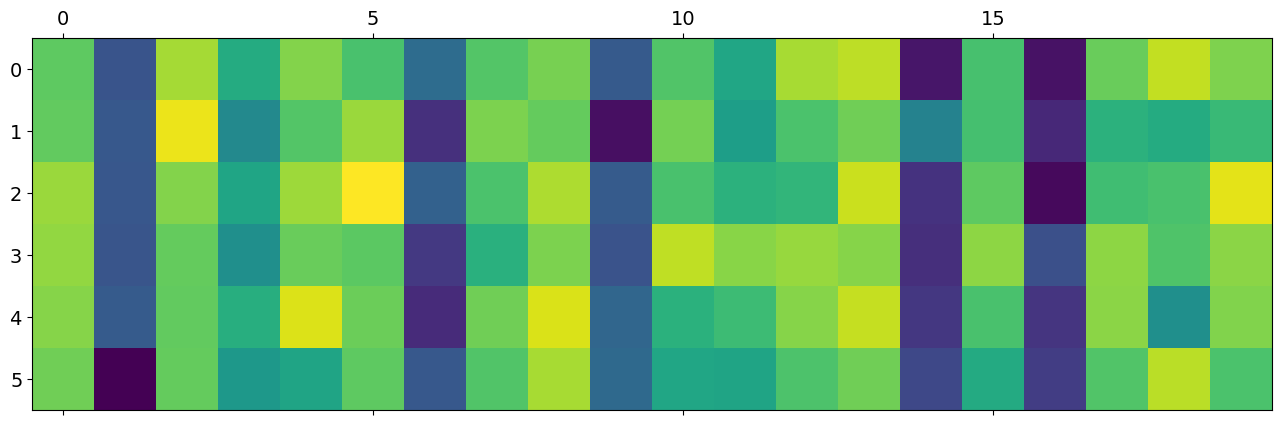

90
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


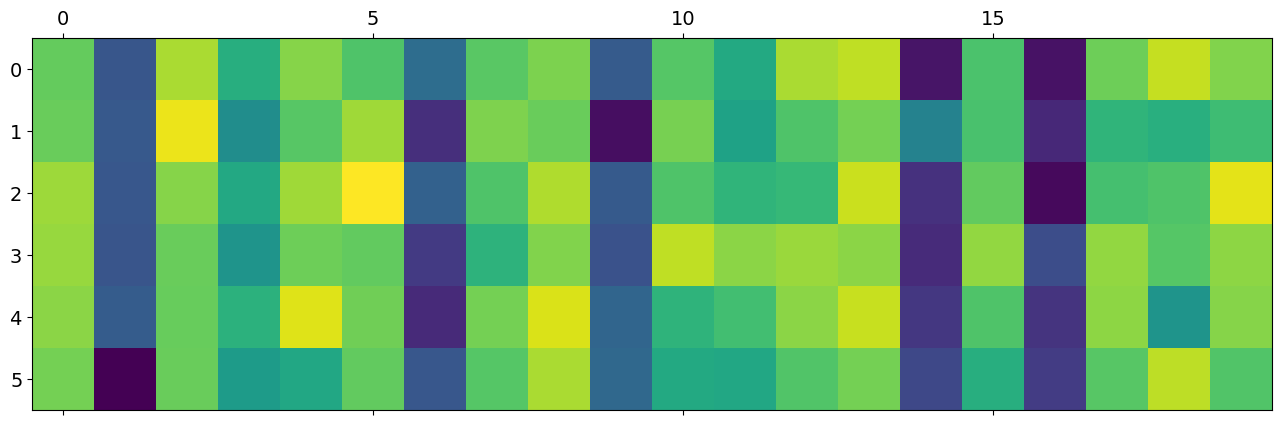

100


In [7]:
# random seed for reproducibility
np.random.seed(seed)
plotgraph(0, rbm.w, M, rbm.a, rbm.b)

# learning rate
l_rate = 5e-1

# minibatch
mini, m = 500, 0

# train model
print('===================================================')
for epoch in range(epochs):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            rbm.init_avg()

        vf = np.copy(v[k])
        for i in np.arange(cdn):
            # positive CD phase: generating h 
            h = rbm.positive(vf, Amp_train)
            # negative CD phase: generating fantasy vf
            vf = rbm.negative(h, Amp_train)
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = rbm.positive(vf, Amp_train)

        rbm.update_vh(v[k], vf, h, hf)
        
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            
            #rbm.ADAM(l_rate_m, epoch+1)
            #rbm.SGD(l_rate_m)
            rbm.RMSprop(l_rate_m)
            m=0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if moving_temperature==True:
        Amp_train -= (Amp_train_mov_init - Amp_train_mov_end)/epochs
    print(Amp_train)
    if epoch%10==9:
        plt.matshow(rbm.w.T)
        plt.show()
        print(epoch+1)
#         plotgraph(epoch+1, rbm.w, M, rbm.a, rbm.b )
#         print('l_rate = ',l_rate)

In [8]:
# from IPython.display import display_html 
# import pandas as pd

# ampl=Amp

# # original, non-reshuffled data in v0
# v1 = np.zeros_like(v0)
# for k in range(N):
#     # positive CD phase: generating h 
#     h = rbm.positive(v0[k],ampl)
#     # negative CD phase: generating fantasy vf with low T == large GAP
#     v1[k] = rbm.negative(h,ampl)
# # difference between fantasy and data
# diff = (v1 - v0)/2
# str0 = fname+'_M'+str(M)+'-mini'+str(mini)
# np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
# np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


# def is_one(cell_value):
#     color0 = 'background-color: gray; color: white'
#     color1 = 'background-color: gold;'
#     if type(cell_value) in [float, int]:
#         if cell_value == 1:
#             return color1
#     return color0

# N1=12
# df0 = pd.DataFrame(v0[:N1])
# df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

# df0s = df0.style.set_table_attributes("style='display:inline'")
# df1s = df1.style.set_table_attributes("style='display:inline'")
# df0s.applymap(is_one)
# df1s.applymap(is_one)
# sty = [dict(selector="caption",props=[("font-size", "150%")])]
# df0s.set_caption('Original').set_table_styles(sty)
# df1s.set_caption('Denoised').set_table_styles(sty)

# display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)


In [9]:
#Generation phase
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = rbm.positive(v0[k], Amp_gen)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = rbm.negative(h, Amp_gen)
    

In [10]:
#import function for the table output
from tabulate import tabulate

#function that returns P if an AA is Polar and A if an AA is Apolar
def aa_type(aa):
    if np.sum(aa*[1,1,0,0]>0):
        return "P"
    else:
        return "A"

#function that analyse the polarity of a matrix of AAs
def results_plot(v):
    #the function i written in the 0-1 formalism
    if SPINS:
        v=(v+1)/2
        
    np.random.shuffle(v) #shuffle the data
    
    list_aa=[]
    
    #variables for the error
    err_count=0
    
    
    #calculation of the polarity and the error between two amminoacids
    for i in range(len(v)):
        prec_aa='N'
        for j in range(5):
            aa=v[i, 4*j : 4*j+4]
            aa=aa_type(aa)
            list_aa.append(aa)
            if(aa==prec_aa):
                err_count+=1
            prec_aa=aa
            
    #calculation of the total error
    errors=np.zeros(len(v))
    for i in range(len(v)):
        aminoacids = np.reshape(np.array(v[i, :]), (5,4))
        for a in range(4):
            if list(np.where(aminoacids[a,:]))[0][0] <2 and list(np.where(aminoacids[a+1,:]))[0][0] <2 :
                errors[i]=1
            elif list(np.where(aminoacids[a,:]))[0][0] >1 and list(np.where(aminoacids[a+1,:]))[0][0] >1:
                errors[i]=1
    err_total = (sum(errors)*100)/len(v)

        
    #print of the errors           
    print('Number of error:', err_count)
    print('Number of couple:', 4*len(v))
    print('Percentage of error:', err_count/(4*len(v))*100, '%')
    print('Percentage of total error:', err_total,'%')
    
    out=np.reshape(np.array(list_aa), (len(v), 5))
    
    # Generate the table with results
    table = tabulate(out[1:10, :], tablefmt="fancy_grid")
    
    print(table)

In [11]:
results_plot(v1)

Number of error: 85
Number of couple: 40000
Percentage of error: 0.21250000000000002 %
Percentage of total error: 0.58 %
╒═══╤═══╤═══╤═══╤═══╕
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
╘═══╧═══╧═══╧═══╧═══╛


# Distribution of the 4 types of amino acids in the fantasy particles

In [12]:
#function that plots for % autovectors of the energy as a function of the position on the protein  
def distr_ami(v, v1=v1):
    
    if np.array_equal(v,v1) and SPINS:
        v = (v+1)/2
    
    csi1 = np.array([1,0,0,0])    
    csi2 = np.array([0,1,0,0])   
    csi3 = np.array([0,0,1,0])    
    csi4 = np.array([0,0,0,1])

    #ami_disteach is a matrix, every row is a protein, each entrance of the row will be filled with the autovector assosiated 
    #with the aminoacid in that position. Initially it is set to zeros
    ami_distr = np.zeros((10000,5), dtype=int)

    #assign to every amino acid its autovector as a single number
    #for example if the aminoacid==csi2 than the position of the aminoacid in the ami_distr is filled with a 2
    for i in range(len(v)):
            aminoacids = np.reshape(np.array(v[i, :]), (5,4))
            for a in range(5): 
                if np.array_equal(aminoacids[a], csi1):
                    ami_distr[i,a] = 1
                elif np.array_equal(aminoacids[a], csi2):
                    ami_distr[i,a] = 2
                elif np.array_equal(aminoacids[a], csi3):
                    ami_distr[i,a] = 3
                elif np.array_equal(aminoacids[a], csi4):
                    ami_distr[i,a] = 4

    print('Type of amino acids in the proteins:', '\n','\n', ami_distr)

    label = ['csi1', 'csi2', 'csi3', 'csi4']
    bar_labels = ['polar', '_polar', 'apolar', '_apolar']
    bar_colors = ['tab:red', 'tab:red','tab:blue', 'tab:blue']

    fig, axs = plt.subplots(5)
    fig.set_size_inches(5,15)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    if np.array_equal(v,v1):
        fig.savefig('Amp_train', dpi=100)
    for i in range(5):
        _, counts = np.unique(ami_distr[:,i], return_counts=True)
        axs[i].bar(label, (counts/10000)*100, label=bar_labels, color=bar_colors)
        axs[i].set_ylabel('%')
        axs[i].set_xlabel('Amino acid')
        axs[i].set_title('Position in the protein '+f'{i+1}')
        box = axs[i].get_position()
        axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].grid(linestyle=':')
        
    if np.array_equal(v,v1):
        fig.savefig('Amp_train', dpi=100)

Type of amino acids in the proteins: 
 
 [[2 3 2 3 1]
 [2 3 2 3 1]
 [2 3 2 3 1]
 ...
 [2 3 2 3 1]
 [2 3 2 3 1]
 [2 3 2 3 1]]


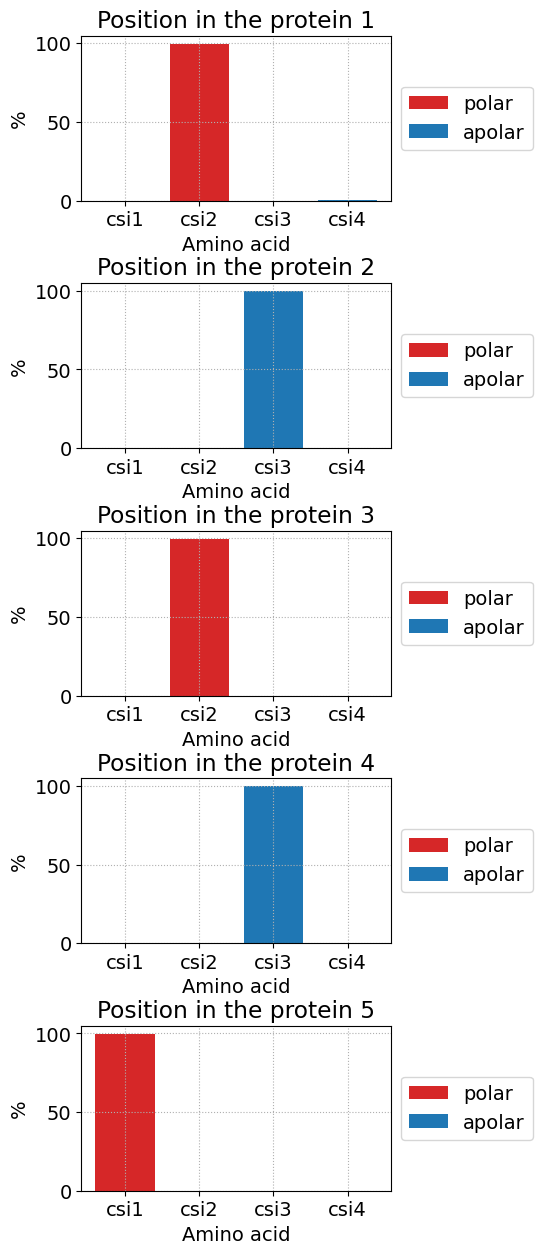

In [13]:
distr_ami(v1)

The distribution is not constant. But the pattern of polar apolar is respected. Also the Asymetry of the distribution seems deepend on the temperature of the training and the ge.  

In [14]:
#same bar plot but with no subplots

# label = ['csi1', 'csi2', 'csi3', 'csi4']
# bar_labels = ['polar', '_polar', 'apolar', '_apolar']
# bar_colors = ['tab:red', 'tab:red','tab:blue', 'tab:blue']
# for i in range(5):
#     _, counts = np.unique(amm_distr[:,i], return_counts=True)
#     plt.bar(label, counts, label=bar_labels, color=bar_colors)
#     plt.title('Amminoacid '+f'{i+1}')
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
#     plt.grid(linestyle=':')
#     plt.show()

# Distribution of the 4 types of amminoacid in the original data

Type of amino acids in the proteins: 
 
 [[3 1 3 2 3]
 [3 1 4 1 4]
 [3 2 4 2 4]
 ...
 [1 3 2 3 2]
 [1 3 1 3 2]
 [2 3 2 4 3]]


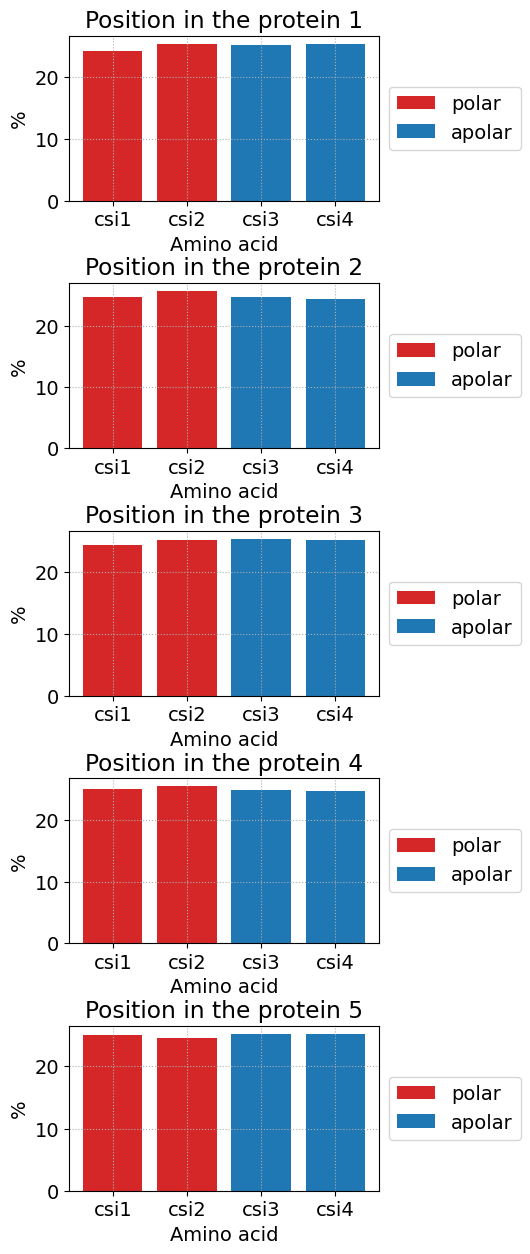

In [15]:
distr_ami(v0)